In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:

df = pd.read_csv("StudentsPerformance.csv")
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:

print("Rows, columns:", df.shape)
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
df.describe().T


Rows, columns: (1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Missing values per column:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score    

,count,mean,std,min,25%,50%,75%,max
math score,1000.0,66.089,15.163080,0.0,57.00,66.0,77.0,100.0
reading score,1000.0,69.169,14.600192,17.0,59.00,70.0,79.0,100.0
writing score,1000.0,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


In [4]:

le = LabelEncoder()
cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Preview
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


PerformanceLevel
Medium    517
Low       285
High      198
Name: count, dtype: int64


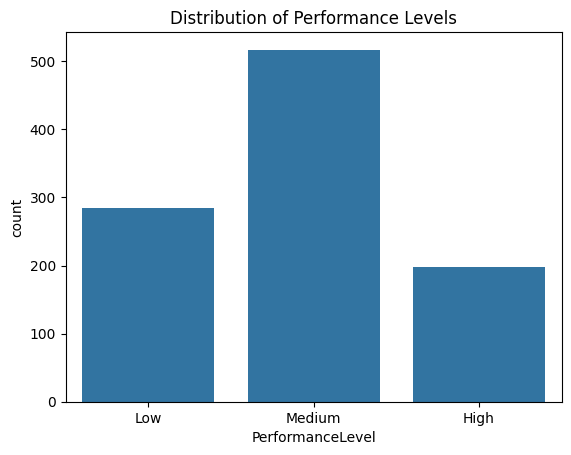

In [5]:
# Create overall score as average of three scores
df['overall_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

# Categorize performance into Low / Medium / High
def categorize(score):
    if score < 60:
        return "Low"
    elif 60 <= score < 80:
        return "Medium"
    else:
        return "High"

df['PerformanceLevel'] = df['overall_score'].apply(categorize)

# Show distribution
print(df['PerformanceLevel'].value_counts())
sns.countplot(x='PerformanceLevel', data=df, order=['Low','Medium','High'])
plt.title("Distribution of Performance Levels")
plt.show()


In [6]:

# Drop raw scores and derived columns not used as features
X = df.drop(['math score', 'reading score', 'writing score', 'overall_score', 'PerformanceLevel'], axis=1)
y = df['PerformanceLevel']

# Quick check
X.columns, X.shape, y.shape


(Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
        'test preparation course'],
       dtype='object'),
 (1000, 5),
 (1000,))

In [7]:
#  Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (800, 5) Test size: (200, 5)


In [8]:
# Build a pipeline and train Random Forest ---
pipeline = Pipeline([
    ("scaler", StandardScaler()),           # scales numerical features for nicer feature importance plotting (RF not required but OK)
    ("rf", RandomForestClassifier(random_state=42, n_estimators=200))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


Accuracy: 0.4850

Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.25      0.28        40
         Low       0.46      0.42      0.44        57
      Medium       0.54      0.61      0.58       103

    accuracy                           0.48       200
   macro avg       0.44      0.43      0.43       200
weighted avg       0.47      0.48      0.48       200



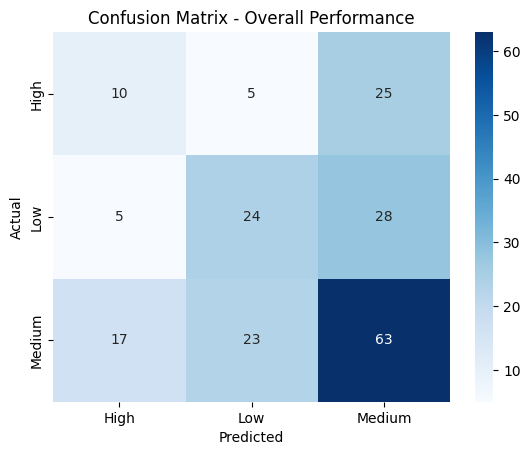

In [9]:
#  Evaluate model ---
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Overall Performance")
plt.show()


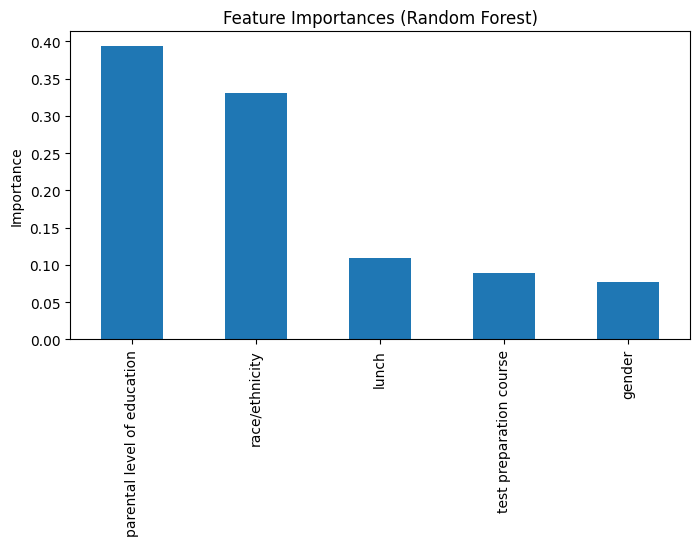

parental level of education    0.393585
race/ethnicity                 0.330977
lunch                          0.109539
test preparation course        0.088682
gender                         0.077217
dtype: float64


In [10]:
# Feature importance (from RandomForest) ---
# Extract the RandomForest inside the pipeline
rf = pipeline.named_steps['rf']
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.show()
print(feat_imp)


In [11]:
# Compare with Logistic Regression & KNN quickly ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = {
    "RandomForest": pipeline,
    "LogisticRegression": Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=500))]),
    "KNN": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
}

scores = {}
for name, mdl in models.items():
    # use cross_val_score on training set for quick comparison
    cv_scores = cross_val_score(mdl, X_train, y_train, cv=5, scoring='accuracy')
    scores[name] = (cv_scores.mean(), cv_scores.std())
    
scores


{'RandomForest': (np.float64(0.4125), np.float64(0.02850438562747845)),
 'LogisticRegression': (np.float64(0.53625), np.float64(0.02143303524935281)),
 'KNN': (np.float64(0.40874999999999995), np.float64(0.043229041164476456))}

In [12]:
#  Save the trained model
import joblib
joblib.dump(pipeline, "student_perf_rf_pipeline.joblib")
print("Saved model to student_perf_rf_pipeline.joblib")


Saved model to student_perf_rf_pipeline.joblib
